# RSCV Model building

### Import Modules

In [1]:
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.stats import randint

In [2]:
print(np.__version__)

2.0.0


In [3]:
import sklearn

sklearn.show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 70.0.0
        numpy: 2.0.0
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


In [4]:
# sys.path.clear()

# Basepath
basepath = "../"  # Project directory
sys.path.append(basepath)

# Data
DATA_PATH = basepath + "data"

# Results path
RESULTS_PATH = basepath + "03_Modelling/03_1_rscv/rscv_results/krr/"

# Figure path
FIGURE_PATH = basepath + "03_Modelling/03_1_rscv/rscv_figures/krr/"

# Path to environment
ENV_PATH = "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib"

# Modelpath
MODEL_PATH = basepath + "models"

# Logging
LOG_DIR = basepath + "03_Modelling/03_1_rscv/"

# Active Learning library
AL_PATH = basepath + "al_lib"

# Add the paths
sys.path.extend(
    {DATA_PATH, FIGURE_PATH, ENV_PATH, MODEL_PATH, RESULTS_PATH, LOG_DIR, AL_PATH}
)
sys.path  # Check if the path is correct

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 '../03_Modelling/03_1_rscv/',
 '../03_Modelling/03_1_rscv/rscv_figures/krr/',
 '../models',
 '../al_lib',
 '../03_Modelling/03_1_rscv/rscv_results/krr/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../data']

### Logging

In [5]:
LOG_DIR

'../03_Modelling/03_1_rscv/'

In [6]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Define the notebook name and the output name
notebook_name = "03_1_rscv_krr.ipynb"  # Is also used when saving the notebook
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Specify logging location
log_file_name = f"{notebook_name.split('.')[0]}_{date}.log"
log_file_dir = f"{LOG_DIR}"
log_file_path = f"{LOG_DIR}/{log_file_name}"


# Get the logger
# logger = None
logging = create_logger(__name__, log_file_path=log_file_path)

# Usage of the logger as follows:
logging.info("Logging started")
logging.info(f"Log file path: {log_file_path}")

2024-06-24 04:07:08 - INFO - Logging started
2024-06-24 04:07:08 - INFO - Log file path: ../03_Modelling/03_1_rscv//03_1_rscv_krr_2024-06-24.log


### Import Data

#### Import PS20191107_2deriv_gegl.csv

In [7]:
# Import 2nd_deriv

data_ps2019_2deriv = pd.read_csv(
    DATA_PATH + "/PS20191107_2deriv_gegl.csv",
    on_bad_lines="skip",
    sep=";",
    decimal=",",
    encoding="utf-8",
)

data_ps2019_2deriv = data_ps2019_2deriv.rename(columns={"Unnamed: 0": "Name"})

# Convert all columns of type 'object' to 'float' or 'int' if possible
for column in data_ps2019_2deriv.columns:
    # change datatype from the 'year' column to 'int
    if column == "year":
        data_ps2019_2deriv[column] = data_ps2019_2deriv[column].astype("int")
        print(f"'{column}' has been converted to 'int'.")
        # skip the rest of the loop
        continue
    try:
        data_ps2019_2deriv[column] = data_ps2019_2deriv[column].astype("float")
        # data_small.select_dtypes(include=['object']).astype('float')
    except ValueError:
        print(f"'{column}' could not be converted(ValueError). Continue with other column(s).")
    except TypeError:
        print(f"'{column}' could not be converted(TypeError). Continue with other column(s).")

'Name' could not be converted(ValueError). Continue with other column(s).
'year' has been converted to 'int'.
'Origin' could not be converted(ValueError). Continue with other column(s).
'type' could not be converted(ValueError). Continue with other column(s).


In [8]:
data_ps2019_2deriv.shape  # for quality control purposes

(2244, 1870)

## Select Data

In [9]:
# Switch for the dataset
# Select from (data_small, data_full, data_2nd_deriv) or other if implemented
data_raw = data_ps2019_2deriv
data_raw.dataset_name = "data_ps2019_2deriv"
logging.info(f"Dataset: {data_raw.dataset_name}")
logging.info(f"Size of the dataset: {data_raw.shape}")

2024-06-24 04:07:10 - INFO - Dataset: data_ps2019_2deriv
2024-06-24 04:07:10 - INFO - Size of the dataset: (2244, 1870)


## Modelling Parameters

In [10]:
# Define the parameters for the CV

# Switch for testing mode (use only 10% of the data, among others)
testing = True

# Define a random state for randomized processes
random_state = np.random.RandomState(202375)

if testing == True:
    nfolds = 5
    NoTrials = 5
    n_jobs = 20
    save_model = False
    # data = data_raw.sample(frac=0.15, random_state=random_state)
    data = data_raw
    logging.info(f"Size of the dataset reduced: {data.shape}")
else:
    nfolds = 10
    NoTrials = 15
    n_jobs = 30
    save_model = True
    data = data_raw
    logging.info(f"Size of the dataset not reduced: {data.shape}")

# Log the modelling parameters
logging.info(
    f"Testing for Cross Validation: {testing}, nfolds: {nfolds}, NoTrials: {NoTrials}, n_jobs: {n_jobs}"
)

2024-06-24 04:07:10 - INFO - Size of the dataset reduced: (2244, 1870)
2024-06-24 04:07:10 - INFO - Testing for Cross Validation: True, nfolds: 5, NoTrials: 5, n_jobs: 20


## Preprocessing

To apply the models we need to split the data into the variables and target.

In [11]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [12]:
data.dtypes.value_counts()

float64    1866
object        3
int64         1
Name: count, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Columns: 1870 entries, Name to 399
dtypes: float64(1866), int64(1), object(3)
memory usage: 32.0+ MB


In [14]:
data.describe()

,year,3996,3994,3992,3990,3988,3987,3985,3983,3981,...,417,415,413,411,409,407,405,403,401,399
count,2244.000000,2244.0,2244.0,2244.0,2244.0,2244.0,2244.0,2244.000000,2244.000000,2244.000000,...,2244.000000,2244.000000,2.244000e+03,2244.000000,2244.0,2244.0,2244.0,2244.0,2244.0,2244.0
mean,-152.291889,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,-0.000002,-0.000005,...,-0.000006,-0.000003,9.369062e-07,0.000005,0.0,0.0,0.0,0.0,0.0,0.0
std,3659.189806,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000015,0.000015,...,0.000018,0.000017,1.806985e-05,0.000020,0.0,0.0,0.0,0.0,0.0,0.0
min,-13555.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000090,-0.000085,-0.000096,...,-0.000067,-0.000067,-9.610000e-05,-0.000125,0.0,0.0,0.0,0.0,0.0,0.0
25%,-370.250000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000008,-0.000012,-0.000014,...,-0.000018,-0.000015,-1.002500e-05,-0.000008,0.0,0.0,0.0,0.0,0.0,0.0
50%,1472.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,-0.000002,-0.000005,...,-0.000007,-0.000003,1.090000e-06,0.000005,0.0,0.0,0.0,0.0,0.0,0.0
75%,1806.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000011,0.000007,0.000004,...,0.000004,0.000008,1.300000e-05,0.000018,0.0,0.0,0.0,0.0,0.0,0.0
max,2009.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000073,0.000061,0.000077,...,0.000125,0.000133,1.100000e-04,0.000073,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Split into target and features
# The goal is to predict the year column of the dataset using the spectral data
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((2244, 1866), (2244,))

In [16]:
# count the number of columns with std = 0.0 in X
logging.info(f"Number of columns to be dropped, where std = 0.0 in X: {(X.std() == 0.0).sum()}")

2024-06-24 04:07:14 - INFO - Number of columns to be dropped, where std = 0.0 in X: 12


In [17]:
# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
logging.info(f"Dimensions of X after dropping columns with std = 0.0: {X.shape}")
logging.info(f"Dimensions of Y: {y.shape}")


2024-06-24 04:07:14 - INFO - Dimensions of X after dropping columns with std = 0.0: (2244, 1854)
2024-06-24 04:07:14 - INFO - Dimensions of Y: (2244,)


In [18]:
# Split the data into training and test sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
logging.info(f"random split with testsize {test_size} into training and test sets")


2024-06-24 04:07:14 - INFO - random split with testsize 0.3 into training and test sets


In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# assert the shapes and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

## Define Score metrics

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# create a scorer which calculates Root Mean Squeared Error (RMSE)

# scoring = make_scorer(root_mean_squared_error, greater_is_better=False)
scoring = make_scorer(mean_squared_error, greater_is_better=False, sqrt=True)

logging.info(f"Scorer: {scoring}")

2024-06-24 04:07:14 - INFO - Scorer: make_scorer(mean_squared_error, greater_is_better=False, response_method='predict', sqrt=True)


# Investigating the prediction performance of Kernel Ridge Regression

This code is developed for the investigation of the failure of the krr regression in the universal part of the RSCV. Here the parameter-distributions are defined explicitly. 

[Kernel ridge regression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge) can be optimized using the following parameters: 

- **alpha** 
    - Regularization strength
- **kernel**
    - Kernel mapping used internally
- **gamma**
    -  Gamma parameter for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels
- **degree** 
    - Degree of the polynomial kernel
- **coef0** 
    - Zero coefficient for polynomial and sigmoid kernels
- **kernel_params**
    - Additional parameters (keyword arguments) for kernel function


In [21]:
from sklearn.kernel_ridge import KernelRidge as KRR
from scipy.stats import uniform

alpha_dist = uniform(loc=1e-3, scale=1e-1) # controls 'complexity'
gamma_dist = uniform(loc=1e-3, scale=1e-1) # controls 'smoothness'
kernel_list = ['linear', 'poly', 'polynomial', 'rbf',]
krr_rscv_parameters = {"alpha": alpha_dist, "gamma": gamma_dist, "kernel": kernel_list}

In [22]:
scoring

make_scorer(mean_squared_error, greater_is_better=False, response_method='predict', sqrt=True)

In [25]:
from al_lib.helper_functions import rmse_func as rmse
from al_lib.helper_functions import report_model
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import (
    mean_squared_error,
)  # also imports the neg_root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer


# create a scorer which calculates Root Mean Squeared Error (RMSE)


def rscv(
    features,
    target,
    model,
    param_distributions,
    results_file,
    random_state,
    NoTrials=5,
    nfolds=4,
    n_jobs=5,
    scoring=scoring, #
):
    """_summary_

    Args:
        features (_type_): _description_
        target (_type_): _description_
        model (_type_): _description_
        param_distributions (_type_): _description_
        results_file (_type_): _description_
        random_state (_type_): _description_
        NoTrials (int, optional): _description_. Defaults to 5.
        nfolds (int, optional): _description_. Defaults to 4.
        n_jobs (int, optional): _description_. Defaults to 5.
        scoring (_type_, optional): _description_. Defaults to scoring.

    Returns:
        _type_: _description_
    """
    logging.info(f"STARTED the RandomizedSearchCV for {model} with {NoTrials} trials")
    # log the args
    logging.info(
        f"Features: {features.shape}, Target: {target.shape}, Model: {model}, Param_distributions: {param_distributions}, Results File: {results_file} Random_state: {random_state}, NoTrials: {NoTrials}, nfolds: {nfolds}, n_jobs: {n_jobs}, Scoring: {scoring}"
    )
    logging.info(f"Results file: {results_file}")

    # prepare the result object 1
    rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])

    # define the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state
    )
    # create the result objects 2
    rscv_rmse_inner = np.zeros(NoTrials)
    rscv_rmse_outer = np.zeros(NoTrials)

    for i in range(NoTrials):
        logging.info(f"Trial: {i} out of {NoTrials}")
        # split for nested cross-validation
        inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

        # non-nested parameter search and scoring
        rscv = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            cv=inner_cv,
            random_state=random_state,
            scoring=scoring,

            n_jobs=n_jobs,
        )

        # fit
        rscv.fit(X_train, y_train)
        # make predictions to later estimate the generalization error
        y_pred = cvp(rscv, X_test, y_test, cv=outer_cv, n_jobs=n_jobs)
        all_predictions = np.zeros((len(y_test), NoTrials))
        all_predictions[:, i] = y_pred
        # calculate the RMSE for the inner and outer CV
        rscv_rmse_inner[i] = rscv.best_score_

        # calculate the RMSE for the outer CV
        # rscv_rmse_outer[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_rmse_outer[i] = rmse(y_test, y_pred)
        # store the results
        rscv_results.loc[i, "model"] = rscv.estimator
        rscv_results.loc[i, "MAE"] = mean_absolute_error(y_test, y_pred)
        rscv_results.loc[i, "RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_results.at[i, "params"] = rscv.best_params_
        report_model(rscv)

    # write results into outputifle
    rscv_results.to_csv(results_file, index=False, mode="a")
    logging.info(f"FINISHED the RandomizedSearchCV for {model} with {NoTrials} trials")
    return rscv_results
    # the goal of the rscv is to find the optimal hyperparameters
    # for further investigation we want to store
    # the 10 best model parameters and their scores
    # both the inner and outer cv scores, as well as the score difference

In [ ]:
# lets rewrite the rscv function to minimize the functionality and to make it more readable

def rscv_simple(
    features,
    target,
    model,
    param_distributions, 
    results_file,
):
    """_summary_

    Args:
        features (_type_): _description_
        target (_type_): _description_
        model (_type_): _description_
        param_distributions (_type_): _description_
        results_file (_type_): _description_
        random_state (_type_): _description_
        NoTrials (int, optional): _description_. Defaults to 5.
        nfolds (int, optional): _description_. Defaults to 4.
        n_jobs (int, optional): _description_. Defaults to 5.
        scoring (_type_, optional): _description_. Defaults to scoring.

    Returns:
        _type_: _description_
    """
    # prepare the result object 1
    rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])

    # define the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state
    )
    # create the result objects 2
    rscv_rmse_inner = np.zeros(NoTrials)
    rscv_rmse_outer = np.zeros(NoTrials)

    for i in range(NoTrials):
        print(f"Trial: {i} out of {NoTrials}")
        # split for nested cross-validation
        inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

        # non-nested parameter search and scoring
        rscv = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            cv=inner_cv,
            random_state=random_state,
            scoring=scoring,

            n_jobs=n_jobs,
        )

        # fit
        rscv.fit(X_train, y_train)
        # make predictions to later estimate the generalization error
        y_pred = cvp(rscv, X_test, y_test, cv=outer_cv, n_jobs=n_jobs)
        all_predictions = np.zeros((len(y_test), NoTrials))
        all_predictions[:, i] = y_pred
        # calculate the RMSE for the inner and outer CV
        rscv_rmse_inner[i] = rscv.best_score_

        # calculate the RMSE for the outer CV
        # rscv_rmse_outer[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_rmse_outer[i] = rmse(y_test, y_pred)
        # store the results
        rscv_results.loc[i, "model"] = rscv.estimator
        rscv_results.loc[i, "MAE"] = mean_absolute_error(y_test, y_pred)
        rscv_results.loc[i, "RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_results.at[i, "params"] = rscv.best_params_
        report_model(rscv)

    # write results into outputifle
    rscv_results.to_csv(results_file, index=False, mode="a")
    logging.info(f"FINISHED the RandomizedSearchCV for {model} with {NoTrials} trials")
    return rscv_results
    # the goal of the rscv is to find the optimal hyperparameters
    # for further investigation we want to store
    # the 10 best model parameters and their scores
    # both the inner and outer cv scores, as well as the score difference

## RBF-Kernel

In [33]:
# define the hyperparameter distribution for the KRR model with the rbf kernel

alpha_dist = uniform(loc=1e-2, scale=1) # controls 'complexity'
gamma_dist = uniform(loc=1e-3, scale=1e-1) # controls 'smoothness'
kernel = ['rbf'] # [‘additive_chi2’, ‘chi2’, ‘linear’, ‘poly’, ‘polynomial’, ‘rbf’, ‘laplacian’, ‘sigmoid’, ‘cosine’]

In [44]:
# improved hyperparameter distributions
from scipy.stats import randint, loguniform

alpha= loguniform(a=1e-3, b=1e3)  # Regularization strength
gamma= loguniform(a=1e-3, b=1e3)  # Kernel coefficient for ‘rbf’

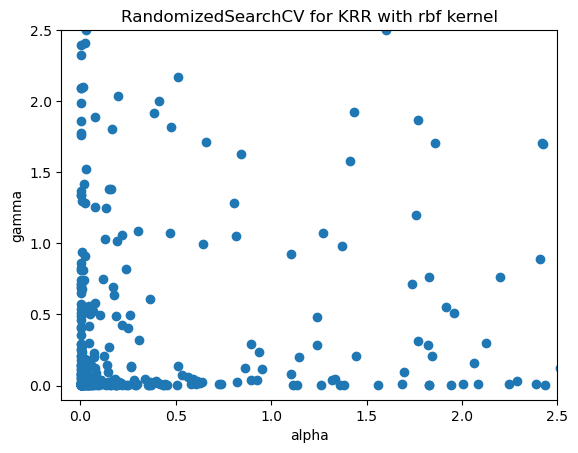

In [54]:
# select 100 values from the distribution and plot them
alpha_values = alpha.rvs(1000)
gamma_values = gamma.rvs(1000)

plt.scatter(alpha_values, gamma_values)
plt.xlabel("alpha")
plt.xlim(-0.1,2.5)
plt.ylabel("gamma")
plt.ylim(-0.1,2.5)
plt.title("RandomizedSearchCV for KRR with rbf kernel")
plt.show()

In [56]:
from scipy.stats import randint, loguniform

# Define the hyperparameter distributions
param_distributions = {
    'alpha': loguniform(a=1e-3, b=1e3),  # Regularization strength
    'gamma': loguniform(a=1e-3, b=1e3),  # Kernel coefficient for ‘rbf’
}

krr_rbf_results_file = f"{RESULTS_PATH}krr_rbf_investigation_results.csv"

# Example usage in rscv
krr_rbf_rscv = rscv(
    features=X,
    target=y,
    model=KRR(kernel='rbf'),  # Ensure the model uses the RBF kernel
    param_distributions=param_distributions,
    results_file=krr_rbf_results_file,
    random_state=random_state,
    NoTrials=10,
    nfolds=10,
    n_jobs=30,
    scoring="neg_root_mean_squared_error",
)

2024-06-24 04:42:45 - INFO - STARTED the RandomizedSearchCV for KernelRidge(kernel='rbf') with 10 trials
2024-06-24 04:42:45 - INFO - Features: (2244, 1854), Target: (2244,), Model: KernelRidge(kernel='rbf'), Param_distributions: {'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa4534c4c50>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa4534c7e60>}, Results File: ../03_Modelling/03_1_rscv/rscv_results/krr/krr_rbf_investigation_results.csv Random_state: RandomState(MT19937), NoTrials: 10, nfolds: 10, n_jobs: 30, Scoring: neg_root_mean_squared_error
2024-06-24 04:42:45 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results/krr/krr_rbf_investigation_results.csv
2024-06-24 04:42:45 - INFO - Trial: 0 out of 10
2024-06-24 04:42:56 - INFO - Trial: 1 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.0019364344852822624), 'gamma': np.float64(33.068621778361184)}
Best score -2388.9411672174965 for KernelRidge: -2388.9411672174965
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.0019364344852822624),
            gamma=np.float64(33.068621778361184), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:43:06 - INFO - Trial: 2 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.05559871880309797), 'gamma': np.float64(76.51196389976523)}
Best score -3314.1311390331953 for KernelRidge: -3314.1311390331953
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.05559871880309797),
            gamma=np.float64(76.51196389976523), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:43:17 - INFO - Trial: 3 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.013933785938789177), 'gamma': np.float64(822.8115409026229)}
Best score -1957.111571246512 for KernelRidge: -1957.111571246512
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.013933785938789177),
            gamma=np.float64(822.8115409026229), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:43:28 - INFO - Trial: 4 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.03236707729557982), 'gamma': np.float64(628.3724120270508)}
Best score -2331.7675597429447 for KernelRidge: -2331.7675597429447
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.03236707729557982),
            gamma=np.float64(628.3724120270508), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:43:39 - INFO - Trial: 5 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.5554748631032582), 'gamma': np.float64(825.6794696972221)}
Best score -3294.3175043333044 for KernelRidge: -3294.3175043333044
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.5554748631032582),
            gamma=np.float64(825.6794696972221), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:43:50 - INFO - Trial: 6 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.003377952818312651), 'gamma': np.float64(495.95965392571793)}
Best score -1716.0411231560295 for KernelRidge: -1716.0411231560295
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.003377952818312651),
            gamma=np.float64(495.95965392571793), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:44:01 - INFO - Trial: 7 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.027330089802775234), 'gamma': np.float64(810.8853976556966)}
Best score -2179.2028736374323 for KernelRidge: -2179.2028736374323
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.027330089802775234),
            gamma=np.float64(810.8853976556966), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:44:11 - INFO - Trial: 8 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.19033795138837425), 'gamma': np.float64(189.1711018789091)}
Best score -3390.3874856216935 for KernelRidge: -3390.3874856216935
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.19033795138837425),
            gamma=np.float64(189.1711018789091), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:44:23 - INFO - Trial: 9 out of 10


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.00480222162128199), 'gamma': np.float64(16.50969534366786)}
Best score -3028.5684453632903 for KernelRidge: -3028.5684453632903
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.00480222162128199),
            gamma=np.float64(16.50969534366786), kernel='rbf')


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-24 04:44:33 - INFO - FINISHED the RandomizedSearchCV for KernelRidge(kernel='rbf') with 10 trials


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.15892378024596918), 'gamma': np.float64(13.437190114459167)}
Best score -3601.1000838277077 for KernelRidge: -3601.1000838277077
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.15892378024596918),
            gamma=np.float64(13.437190114459167), kernel='rbf')


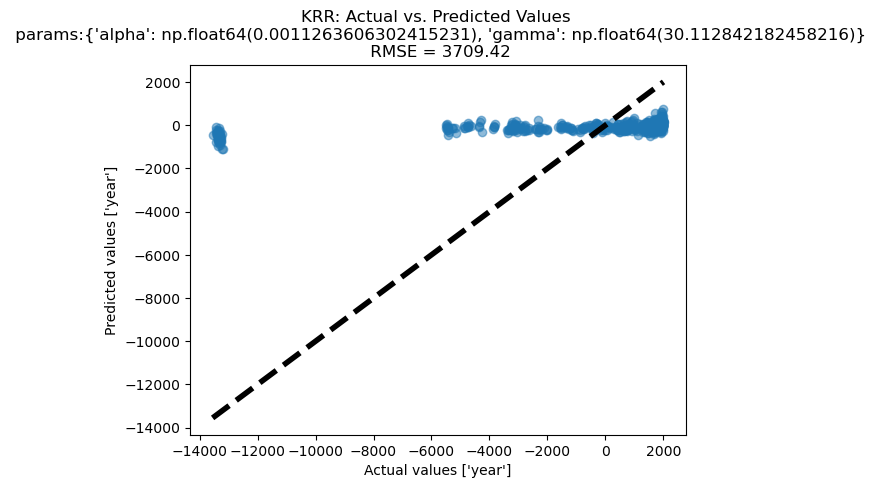

In [57]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
krr_results = pd.read_csv(krr_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_krr = krr_results.loc[krr_results["RMSE"].idxmin(), "params"]
optimal_params_krr = dict(eval(optimal_params_str_krr))

# rf_opt = RandomForestRegressor(**optimal_params_rf)
krr_opt = KRR(**optimal_params_krr)


y_pred_krr = krr_opt.fit(X_train, y_train).predict(X_test)

title_str = (
    f"KRR: Actual vs. Predicted Values \n params:"
    + optimal_params_str_krr
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_krr):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}avp_krr_investigation.png"
fig, ax = plt.subplots(1, 1)
krr_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_krr, param_dict, fig_path)

# KRR with other kernels

In [2]:
from scipy.stats import randint, loguniform

# Define the hyperparameter distributions
param_distributions = {
    'alpha': loguniform(a=1e-6, b=1e6),  # Regularization strength
    'gamma': loguniform(a=1e-3, b=1e6),  # Kernel coefficient for ‘rbf’
    'kernel': ['rbf', 'linear', 'poly', 'polynomial','chi2'],
}

In [ ]:


krr_kernels_results_file = f"{RESULTS_PATH}krr_kernels_investigation_results.csv"


krr_kernels_rscv = rscv(
    features=X,
    target=y,
    model=KRR(), 
    param_distributions=param_distributions,
    results_file=krr_kernels_results_file,
    random_state=random_state,
    NoTrials=15,
    nfolds=10,
    n_jobs=30,
    scoring="neg_root_mean_squared_error",
)

In [ ]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
krr_kernel_results = pd.read_csv(krr_kernels_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_krr = krr_kernel_results.loc[krr_kernel_results["RMSE"].idxmin(), "params"]
optimal_params_krr = dict(eval(optimal_params_str_krr))

# rf_opt = RandomForestRegressor(**optimal_params_rf)
krr_opt = KRR(**optimal_params_krr)


y_pred_krr = krr_opt.fit(X_train, y_train).predict(X_test)

title_str = (
    f"KRR -Kernel test: Actual vs. Predicted Values \n params:"
    + optimal_params_str_krr
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_krr):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}avp_krr_investigation.png"
fig, ax = plt.subplots(1, 1)
krr_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_krr, param_dict, fig_path)

In [5]:
# 

for kernel in param_distributions['kernel']:
    print(kernel)

rbf
linear
poly
polynomial
chi2
